In [ ]:
NAME = "Maya Gharat"
COLLABORATORS = "N/A"

<div class="alert alert-block alert-info">
<h3>Student Information</h3> Please provide information about yourself.<br>
<b>Name</b>: Maya Gharat<br> 
<b>NetID</b>: mpg126<br>
<b>Recitation #</b>: 2<br>
<b>Notes to Grader</b> (optional): <br>
<br><br>
<b>IMPORTANT</b>
Your work will not be graded withour your initials below<br>
I certify that this lab represents my own work and I have read the RU academic intergrity policies at<br>
<a href="https://www.cs.rutgers.edu/academic-integrity/introduction">https://www.cs.rutgers.edu/academic-integrity/introduction </a><br>
<b>Initials</b>: MG     (eg: NC for Naina Chaturvedi)

### Pip Installations

In [30]:
!pip install Unidecode

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Import Libraries

In [31]:
import pandas as pd
import re
import nltk
import unicodedata
import chardet
import numpy as np 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from unidecode import unidecode
from scipy.sparse import hstack
from nltk.corpus import words

from sklearn.metrics.pairwise import cosine_similarity



In [32]:
nltk.download('words')
english_words = set(words.words())

[nltk_data] Downloading package words to /home/mpg126/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [33]:
def clean_text(text):
    if not isinstance(text, str):
        return text

    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Content-Based Filtering (Dataset #1)

**The goal of this portion of the project is to recommend books to a user based on feature similarity.**

### Load Data and Inspect

Since the data was not UTF-8 encoded, the correct encoding to parse the data was determined.

In [34]:
import chardet

with open("books.csv", 'rb') as f:
    result = chardet.detect(f.read(10000))
    print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [35]:
df = pd.read_csv("books.csv",sep=';',encoding=result['encoding'],on_bad_lines='skip')

display(df.head())
df.info()

/tmp/ipykernel_806247/699389647.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("books.csv",sep=';',encoding=result['encoding'],on_bad_lines='skip')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


### Clean Data
Since some of the columns such as ISBN, image urls, and publisher were irrelevant feature on which to determine book similairty these were removed. 

In [36]:
df = df.drop(df.columns[3:22],axis=1)
df = df.drop(df.columns[0],axis =1)
display(df.head())
df.info()

,Book-Title,Book-Author
0,Classical Mythology,Mark P. O. Morford
1,Clara Callan,Richard Bruce Wright
2,Decision in Normandy,Carlo D'Este
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,The Mummies of Urumchi,E. J. W. Barber


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Book-Title   271360 non-null  object
 1   Book-Author  271358 non-null  object
dtypes: object(2)
memory usage: 4.1+ MB


Null values were inspected and the rows found with null authors were removed. 

In [37]:
print(df.isnull().sum())
df[df.isnull().any(axis=1)]
df = df[df["Book-Author"].notnull()] 
df.info()
df = df.rename(columns = {"Book-Title":"Title", "Book-Author":"Author"})
#display(df.head())

Book-Title     0
Book-Author    2
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 271358 entries, 0 to 271359
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Book-Title   271358 non-null  object
 1   Book-Author  271358 non-null  object
dtypes: object(2)
memory usage: 6.2+ MB


### Data Preprocessing
The data was preprocessing and correctly formatted. Accents, uppercased letter, extra spaces and other test noise were removed to ensure that duplcaite items did not remain on the basis of formatting difference. Similar book title endings were also filtered out to avoid similarity based on terms like "paperback edition".  

In [38]:
df = df.drop_duplicates(subset="Title")


def clean_text(text):
    if not isinstance(text, str):
        return text

    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    text = text.lower()

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


df['Title'] = df['Title'].apply(clean_text)
df['Author'] = df['Author'].apply(clean_text)


df['Title'] = df['Title'].str.replace('(Penguin Popular Classics)', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Newbery Medal Books?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Random House', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Paperback', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'(penguin\s?english\s)?library', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Signet Classics?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Bantam Classics?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Puffin Classics?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r"\(?World'?s Classics\)?", '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'\bModern?\s*Classics?\b', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r"\(?Oxford World'?s Classics\)?", '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Modern Library', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Dover Thrift Editions', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace('Large Print', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'Wordsworth\s+Classics?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'Everyman\s+Classics?', '', case=False, regex=True).str.strip()

specialChar =  r'[^\w\s]'
df['Title'] = df['Title'].replace(specialChar, '', regex=True)
df['Title'] = df['Title'].str.replace('amp', '', case=False, regex=True).str.strip()

df['Title'] = df['Title'].str.replace(r'\d+', '', regex=True)
df['Author'] = df['Author'].str.replace(r'\d+', '', regex=True)

df = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
df["Author"] = df["Author"].str.replace(" ", "")

df['Title'] = df['Title'].str.strip()
df['Author'] = df['Author'].str.strip()


df["merged"] = df['Title'].str.cat(df['Author'], sep=" ")

df = df.drop_duplicates(subset="Title")

df = df.reset_index(drop=True)

#print(df.isnull().sum())

df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234231 entries, 0 to 234230
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Title   234231 non-null  object
 1   Author  234231 non-null  object
 2   merged  234231 non-null  object
dtypes: object(3)
memory usage: 5.4+ MB


,Title,Author,merged
0,classical mythology,markpomorford,classical mythology markpomorford
1,clara callan,richardbrucewright,clara callan richardbrucewright
2,decision in normandy,carlodeste,decision in normandy carlodeste
3,flu the story of the great influenza pandemic ...,ginabarikolata,flu the story of the great influenza pandemic ...
4,the mummies of urumchi,ejwbarber,the mummies of urumchi ejwbarber


### Count Vectorization, Cosine Similarity, and Recommendation Generation
The first technique used was count vectorization - a bag of words vectorization approach. Recommendations were given for a book within in the dataset. 

In [39]:
df = df[0:10000]

custom_stopwords = ['book', 'paperback', 'volume']
combined_stopwords = list(set(ENGLISH_STOP_WORDS).union(custom_stopwords))

countvectorizer = CountVectorizer(stop_words=custom_stopwords,encoding = 'ISO-8859-1', strip_accents='unicode',token_pattern=r'\b[a-zA-Z]{2,}\b' )
vectorized_data = countvectorizer.fit_transform(df['merged'])

countsimilarities = cosine_similarity(vectorized_data)


bookname = 'the disappearance of sherlock holmes'
name_to_find = bookname
name_exists = df['Title'].isin([name_to_find]).any()

if name_exists:
    print(f"Row with name '{name_to_find}' exists in column 'Title'")
    usersBook = bookname
    countsimilarityDF = pd.DataFrame(countsimilarities, columns=df['Title'], index=df['Title'])
    display(countsimilarityDF)
    countsimilar_scores = countsimilarityDF[usersBook]
    
    countsimilar_scores = countsimilar_scores.drop(usersBook)
    #display(len(countsimilar_scores))
    
    top_matches = countsimilar_scores.nlargest(10)
    Tfrecs = pd.DataFrame(top_matches).reset_index()
    Tfrecs.columns = ['Title', 'Similarity']
    print(Tfrecs)
else:
    print(f"Row with name '{name_to_find}' does not exist in column 'Title'")

Row with name 'the disappearance of sherlock holmes' exists in column 'Title'


Title,classical mythology,clara callan,decision in normandy,flu the story of the great influenza pandemic of and the search for the virus that caused it,the mummies of urumchi,the kitchen gods wife,what if the worlds foremost military historians imagine what might have been,pleading guilty,under the black flag the romance and the reality of life among the pirates,where youll find me and other stories,...,dune,the vision,the face of fear,lost,secret life of laszlo count dracula,cry in night,killing lana,daughters of earth other stories,tea leaf reading llewellyns new age series,as one dead vire the masquerade
Title,,,,,,,,,,,,,,,,,,,,,
classical mythology,1.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000
clara callan,0.0,1.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000
decision in normandy,0.0,0.0,1.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.25,0.0,0.000000,0.0,0.000000
flu the story of the great influenza pandemic of and the search for the virus that caused it,0.0,0.0,0.00,1.000000,0.467099,0.311400,0.179787,0.0,0.636524,0.061546,...,0.0,0.402015,0.467099,0.0,0.131590,0.00,0.0,0.142134,0.0,0.263181
the mummies of urumchi,0.0,0.0,0.00,0.467099,1.000000,0.200000,0.115470,0.0,0.430331,0.000000,...,0.0,0.258199,0.400000,0.0,0.169031,0.00,0.0,0.182574,0.0,0.169031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cry in night,0.0,0.0,0.25,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,1.00,0.0,0.000000,0.0,0.000000
killing lana,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00,1.0,0.000000,0.0,0.000000
daughters of earth other stories,0.0,0.0,0.00,0.142134,0.182574,0.000000,0.000000,0.0,0.078567,0.288675,...,0.0,0.000000,0.182574,0.0,0.154303,0.00,0.0,1.000000,0.0,0.000000


                                               Title  Similarity
0  sherlock holmes and the rune stone mystery fro...    0.666667
1  sherlock holmes and the rune stone mystery she...    0.612372
2           sherlock holmes  the case of sabina hall    0.577350
3                          return of sherlock holmes    0.547723
4  sherlock holmes the complete novels and storie...    0.545545
5  sherlock holmes and the giant rat of sumantra ...    0.492366
6        the eye of the world the wheel of time book    0.481125
7       the fellowship of the ring lord of the rings    0.481125
8  the fellowship of the ring the lord of the rin...    0.480384
9  the flight of the seventh moon the teaching of...    0.480384


### Recommend on New Book - Count Vectorizer
Given a new book vector of title and author, the cosine similarity can be computed based on the vectorized data from the dataset to generate recommendations given a user-inputted book. 

In [40]:
newbook = ["pride and prejudice janeausten"]
newbooktitle = "pride and prejudice"

newbookVector = countvectorizer.transform(newbook)
#print(newbookVector.toarray())

newbooksimilarities = cosine_similarity(newbookVector, vectorized_data)
#print(newbooksimilarities)
newbooksimilarityDF = pd.DataFrame(newbooksimilarities, columns=df['Title'],index = newbook)
display(newbooksimilarityDF)

if newbooktitle in newbooksimilarityDF.columns:
    newbooksimilarityDF = newbooksimilarityDF.drop(columns = [newbooktitle])

#newbookcolumn = newbooksimilarityDF.T
#display(newbookcolumn)

top_matches = newbooksimilarityDF.iloc[0].nlargest(10)
#top_matches = newbookcolumn.iloc[:, 0].nlargest(10)
Tfrecs = pd.DataFrame(top_matches).reset_index()
Tfrecs.columns = ['Title', 'Similarity']
print(Tfrecs)

Title,classical mythology,clara callan,decision in normandy,flu the story of the great influenza pandemic of and the search for the virus that caused it,the mummies of urumchi,the kitchen gods wife,what if the worlds foremost military historians imagine what might have been,pleading guilty,under the black flag the romance and the reality of life among the pirates,where youll find me and other stories,...,dune,the vision,the face of fear,lost,secret life of laszlo count dracula,cry in night,killing lana,daughters of earth other stories,tea leaf reading llewellyns new age series,as one dead vire the masquerade
pride and prejudice janeausten,0.0,0.0,0.0,0.087039,0.0,0.0,0.0,0.0,0.096225,0.176777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


                                               Title  Similarity
0                                   pride  prejudice    0.866025
1                        pride and prejudice the  el    0.816497
2                              sense and sensibility    0.500000
3  love in black and white the triumph of love ov...    0.353553
4                                               emma    0.353553
5                                         persuasion    0.353553
6  lean and luscious and meatless lean and luscio...    0.335410
7                   george and martha rise and shine    0.333333
8  phaedrus and the seventh and eighth letters an...    0.333333
9                 cars and trucks and things that go    0.316228


### TF-IDF Vectorization, Cosine Similarity, and Recommendation Generation
TF-IDF was tested as an alternative method to count vectorization.

In [41]:
def remove_accents_token(text):
    # Normalize unicode and remove diacritics
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])  # Remove diacritics
    return text

#filter out non-english words
def english_word_tokenizer(text):
    text = remove_accents_token(text)
    tokens = re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())
    return [token for token in tokens if token in english_words]

#token_pattern=r'\b[a-zA-Z]{2,}\b'

tfvectorizer = TfidfVectorizer(stop_words=custom_stopwords,encoding = 'ISO-8859-1', strip_accents='unicode', tokenizer = english_word_tokenizer)
tfidf_matrix = tfvectorizer.fit_transform(df['merged'])
#print(tfidf_matrix.shape) 
#print(tfvectorizer.get_feature_names_out())
#matching_rows = df[df['merged'].str.contains('pride and prejudice the  el', case=False, na=False)]
#print(matching_rows)
similarities = cosine_similarity(tfidf_matrix)
#print(similarities)

bookname = 'the disappearance of sherlock holmes'
name_to_find = bookname
name_exists = df['Title'].isin([name_to_find]).any()

if name_exists:
    print(f"Row with name '{name_to_find}' exists in column 'Title'")
    usersBook = bookname
    similarityDF = pd.DataFrame(similarities, columns=df['Title'], index=df['Title'])
    #display(similarityDF)
    similar_scores = similarityDF[usersBook]
    
    similar_scores = similar_scores.drop(usersBook)
    #display(len(similar_scores))
    
    top_matches = similar_scores.nlargest(10)
    Tfrecs = pd.DataFrame(top_matches).reset_index()
    Tfrecs.columns = ['Title', 'Similarity']
    print(Tfrecs)
else:
    print(f"Row with name '{name_to_find}' does not exist in column 'Title'")

/usr/local/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Row with name 'the disappearance of sherlock holmes' exists in column 'Title'
                                               Title  Similarity
0                                  the disappearance    0.761422
1                         sherlock holmes vs dracula    0.612225
2  sherlock holmes the complete novels and storie...    0.569078
3  sherlock holmes and the rune stone mystery fro...    0.498992
4                          return of sherlock holmes    0.491151
5                           complete sherlock holmes    0.470103
6  sherlock holmes the complete novels and storie...    0.467770
7  sherlock holmes and the rune stone mystery she...    0.461359
8                       sherlock holmes encyclopedia    0.418429
9                  six great sherlock holmes stories    0.373060


### Recommend on New Book - TF-IDF

In [42]:
newbook = ["pride and prejudice janeausten"]
newbooktitle = "pride and prejudice"

tfnewbookVector = tfvectorizer.transform(newbook)
#print(newbookVector.toarray())

tfnewbooksimilarities = cosine_similarity(tfnewbookVector, tfidf_matrix)
#print(newbooksimilarities)
tfnewbooksimilarityDF = pd.DataFrame(tfnewbooksimilarities, columns=df['Title'],index = newbook)

if newbooktitle in tfnewbooksimilarityDF.columns:
    tfnewbooksimilarityDF = tfnewbooksimilarityDF.drop(columns = [newbooktitle])

#display(tfnewbooksimilarityDF)
#tfnewbookcolumn = tfnewbooksimilarityDF.T
#display(tfnewbookcolumn.shape)

top_matches = tfnewbooksimilarityDF.iloc[0].nlargest(10)
#top_matches = tfnewbookcolumn.iloc[:, 0].nlargest(10)
Tfrecs = pd.DataFrame(top_matches).reset_index()
Tfrecs.columns = ['Title', 'Similarity']
print(Tfrecs)

                                               Title  Similarity
0                                   pride  prejudice    0.961648
1                        pride and prejudice the  el    0.897326
2                cattlemans pride silhouette romance    0.434693
3     pride of lions celtic world of morgan llywelyn    0.378277
4       oklahoma pride holts an american dynasty vol    0.357872
5  love in black and white the triumph of love ov...    0.338595
6  pride of st charles avenue silhouette special ...    0.282695
7                                    julie and romeo    0.274286
8                           celtic myths and legends    0.274286
9                             narcissus and goldmund    0.274286


### TF-IDF on Title and One-Hot Encoding on Author

In [43]:
#tfvectorizer = TfidfVectorizer(stop_words=custom_stopwords,encoding = 'ISO-8859-1', strip_accents='unicode',token_pattern=r'\b[a-zA-Z]{2,}\b' )
title_tfidf_matrix = tfvectorizer.fit_transform(df['Title'])
encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
one_hot_encoded = encoder.fit_transform(df[["Author"]])
one_hot_encoded_sparse = csr_matrix(one_hot_encoded)

#print(title_tfidf_matrix.shape) 
#print(one_hot_encoded_sparse.shape)

combined_matrix = hstack([title_tfidf_matrix, one_hot_encoded_sparse])

#print(combined_matrix.shape)

combined_similarity = cosine_similarity(combined_matrix)

#print(combined_similarity.shape)


# print(type(title_tfidf_matrix))
# print(type(one_hot_encoded_sparse))  


bookname = 'the disappearance of sherlock holmes'
name_to_find = bookname
name_exists = df['Title'].isin([name_to_find]).any()

if name_exists:
    print(f"Row with name '{name_to_find}' exists in column 'Title'")
    usersBook = bookname
    comsimilarityDF = pd.DataFrame(combined_similarity, columns=df['Title'], index=df['Title'])
    #display(comsimilarityDF)
    comsimilar_scores = comsimilarityDF[usersBook]
    
    comsimilar_scores = comsimilar_scores.drop(usersBook)
    #display(len(similar_scores))
    
    top_matches = comsimilar_scores.nlargest(10)
    Tfrecs = pd.DataFrame(top_matches).reset_index()
    Tfrecs.columns = ['Title', 'Similarity']
    print(Tfrecs)
else:
    print(f"Row with name '{name_to_find}' does not exist in column 'Title'")


/usr/local/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Row with name 'the disappearance of sherlock holmes' exists in column 'Title'
                                               Title  Similarity
0  sherlock holmes and the rune stone mystery fro...    0.749496
1  sherlock holmes and the rune stone mystery she...    0.730679
2                                  the disappearance    0.380711
3                         sherlock holmes vs dracula    0.306113
4  sherlock holmes the complete novels and storie...    0.284539
5                          return of sherlock holmes    0.245576
6                           complete sherlock holmes    0.235051
7  sherlock holmes the complete novels and storie...    0.233885
8                       sherlock holmes encyclopedia    0.209215
9                  six great sherlock holmes stories    0.186530


### Recommend New Book with TF-IDF and One-Hot Encoding

In [44]:
newbookTitle = ["pride and prejudice"]
newbookAuthor = ["janeausten"]

# newbookTitle = ["the catcher in the rye"]
# newbookAuthor = ["j.d.salinger"]

newbooktitleString = newbookTitle[0].lower()

print(newbooktitleString)

comnewbook1 = tfvectorizer.transform(newbookTitle)
comnewbook2 = encoder.transform([newbookAuthor])

comnewbookVector = hstack([comnewbook1,comnewbook2])
print(comnewbookVector.toarray().shape)

comnewbooksimilarities = cosine_similarity(comnewbookVector, combined_matrix)
#print(newbooksimilarities)
comnewbooksimilarityDF = pd.DataFrame(comnewbooksimilarities, columns=df['Title'],index = newbookTitle)

if newbooktitleString in comnewbooksimilarityDF.columns:
    comnewbooksimilarityDF = comnewbooksimilarityDF.drop(columns = [newbooktitleString])

#display(tfnewbooksimilarityDF)
#comnewbookcolumn = comnewbooksimilarityDF.T
#display(tfnewbookcolumn.shape)

top_matches = comnewbooksimilarityDF.iloc[0].nlargest(10)
#top_matches = tfnewbookcolumn.iloc[:, 0].nlargest(10)
Tfrecs = pd.DataFrame(top_matches).reset_index()
Tfrecs.columns = ['Title', 'Similarity']
print(Tfrecs)

pride and prejudice
(1, 11320)
                                     Title  Similarity
0                         pride  prejudice    0.980824
1              pride and prejudice the  el    0.948663
2                    sense and sensibility    0.535451
3                           mansfield park    0.500000
4                                     emma    0.500000
5                         northanger abbey    0.500000
6                               persuasion    0.500000
7          lady susan the watsons sanditon    0.500000
8  persuasion with a memoir of jane austen    0.500000
9      cattlemans pride silhouette romance    0.217346


/usr/local/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# Content-Based Filtering (Dataset #2)
Performing content-based filtering on a dataset with better meta data and blurbs for each book. 

### Load Data and Inspect

In [45]:
blurbdf = pd.read_csv("books_with_blurbs.csv")
display(blurbdf.head())
display(blurbdf.info())

,ISBN,Title,Author,Year,Publisher,Blurb
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57510 entries, 0 to 57509
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ISBN       57510 non-null  object
 1   Title      57510 non-null  object
 2   Author     57510 non-null  object
 3   Year       57510 non-null  int64 
 4   Publisher  57510 non-null  object
 5   Blurb      57510 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.6+ MB


None

### Clean Data

In [46]:
blurbdf = blurbdf.drop(blurbdf.columns[0],axis =1)
blurbdf = blurbdf.drop("Publisher",axis='columns')
display(blurbdf.head())
#print(blurbdf.isnull().sum())

,Title,Author,Year,Blurb
0,Decision in Normandy,Carlo D'Este,1991,"Here, for the first time in paperback, is an o..."
1,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,"The fascinating, true story of the world's dea..."
2,The Kitchen God's Wife,Amy Tan,1991,Winnie and Helen have kept each others worst s...
3,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Historians and inquisitive laymen alike love t...
4,Goodbye to the Buttermilk Sky,Julia Oliver,1994,This highly praised first novel by fiction wri...


### Data Pre-Processing

In [48]:
def normalize_text(text):
    if pd.isnull(text):
        return ""
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def remove_accents(text):
    if pd.isnull(text):
        return ""
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    return text


df['Title'] = df['Title'].apply(normalize_text)
df['Author'] = df['Author'].apply(normalize_text)

df['Title'] = df['Title'].apply(remove_accents)
df['Author'] = df['Author'].apply(remove_accents)

df["Author"] = df["Author"].apply(unidecode)
df["Title"] = df["Title"].apply(unidecode)

blurbdf['Title'] = blurbdf['Title'].str.replace('(Penguin Popular Classics)', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Newbery Medal Books?', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Random House', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Paperback', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace(r'(penguin\s?english\s)?library', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Signet Classics?', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Bantam Classics?', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Puffin Classics?', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace(r"\(?World'?s Classics\)?", '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace(r'\bModern?\s*Classics?\b', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace(r"\(?Oxford World'?s Classics\)?", '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Modern Library', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Dover Thrift Editions', '', case=False, regex=True).str.strip()
blurbdf['Title'] = blurbdf['Title'].str.replace('Large Print', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'Wordsworth\s+Classics?', '', case=False, regex=True).str.strip()
df['Title'] = df['Title'].str.replace(r'Everyman\s+Classics?', '', case=False, regex=True).str.strip()

blurbdf['Title'] = blurbdf['Title'].str.replace(r'\s+', ' ', regex=True).str.strip()

specialChar =  r'[^\w\s]'
blurbdf['Title'] = blurbdf['Title'].replace(specialChar, '', regex=True)
blurbdf['Title'] = blurbdf['Title'].str.replace('amp', '', case=False, regex=True).str.strip()


blurbdf = blurbdf.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
blurbdf["Author"] = blurbdf["Author"].str.replace(" ", "")

blurbdf['Title'] = blurbdf['Title'].str.strip()
blurbdf['Author'] = blurbdf['Author'].str.strip()




blurbdf["merged"] = blurbdf['Title'].str.cat([blurbdf['Author'],blurbdf['Year'].astype(str),blurbdf['Blurb']], sep=" ")
blurbdf["mergedV2"] = blurbdf['Title'].str.cat(blurbdf['Blurb'], sep=" ")


blurbdf = blurbdf.drop_duplicates(subset="Title")

blurbdf = blurbdf.reset_index(drop=True)

#print(blurbdf.isnull().sum())

display(blurbdf.head())

# display(blurbdf.iloc[0])

# # Find rows where 'Title' contains the substring
# matching_rows = df[df['Title'].str.contains("Emma", case=False, na=False)]

# # Print the matching rows
# display(matching_rows)
# print(len(matching_rows))

blurbdf.info()

,Title,Author,Year,Blurb,merged,mergedV2
0,decision in normandy,carlod'este,1991,"here, for the first time in paperback, is an o...","decision in normandy carlod'este 1991 here, fo...","decision in normandy here, for the first time ..."
1,flu the story of the great influenza pandemic ...,ginabarikolata,1999,"the fascinating, true story of the world's dea...",flu the story of the great influenza pandemic ...,flu the story of the great influenza pandemic ...
2,the kitchen gods wife,amytan,1991,winnie and helen have kept each others worst s...,the kitchen gods wife amytan 1991 winnie and h...,the kitchen gods wife winnie and helen have ke...
3,what if the worlds foremost military historian...,robertcowley,2000,historians and inquisitive laymen alike love t...,what if the worlds foremost military historian...,what if the worlds foremost military historian...
4,goodbye to the buttermilk sky,juliaoliver,1994,this highly praised first novel by fiction wri...,goodbye to the buttermilk sky juliaoliver 1994...,goodbye to the buttermilk sky this highly prai...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51265 entries, 0 to 51264
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     51265 non-null  object
 1   Author    51265 non-null  object
 2   Year      51265 non-null  int64 
 3   Blurb     51265 non-null  object
 4   merged    51265 non-null  object
 5   mergedV2  51265 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


### TF-IDF Vecorization on Merged Set #1

In [49]:

blurbdf = blurbdf[0:20000]
blurb_tfidf_matrix = tfvectorizer.fit_transform(blurbdf['merged'])

#print(blurb_tfidf_matrix.shape) 

blurbsimilarities = cosine_similarity(blurb_tfidf_matrix)
#print(blurbsimilarities)

#bookname = 'harry potter and the prisoner of azkaban book 3'
bookname = 'emma'
name_to_find = bookname
name_exists = blurbdf['Title'].isin([name_to_find]).any()

if name_exists:
    print(f"Row with name '{name_to_find}' exists in column 'Title'")
    usersBook = bookname
    blurbsimilarityDF = pd.DataFrame(blurbsimilarities, columns=blurbdf['Title'], index=blurbdf['Title'])
    display(blurbsimilarityDF.head())
    blurbsimilar_scores = blurbsimilarityDF[usersBook]
    
    blurbsimilar_scores = blurbsimilar_scores.drop(usersBook)
    #display(len(blurbsimilar_scores))
    
    top_matches = blurbsimilar_scores.nlargest(10)
    Tfrecs = pd.DataFrame(top_matches).reset_index()
    Tfrecs.columns = ['Title', 'Similarity']
    print(Tfrecs)
else:
    print(f"Row with name '{name_to_find}' does not exist in column 'Title'")



/usr/local/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Row with name 'emma' exists in column 'Title'


Title,decision in normandy,flu the story of the great influenza pandemic of 1918 and the search for the virus that caused it,the kitchen gods wife,what if the worlds foremost military historians imagine what might have been,goodbye to the buttermilk sky,the testament,beloved plume contemporary fiction,our dumb century the onion presents 100 years of headlines from americas finest news source,new vegetarian bold and beautiful recipes for every occasion,tell me this isnt happening,...,if i could drive an ambulance tonka,hug,garfield goes to disobedience school,dk readers jobs people do a day in a life of a builder level 1 beginning to read,the cat that climbed the christmas tree little golden book,sammy the seal i can read book 1,crocodiles knowitalls hardcover,furrever friends,walt disneys pinocchio and his puppet show adventure disneys wonderful world of reading series number 10,working hard with the mighty loader
Title,,,,,,,,,,,,,,,,,,,,,
decision in normandy,1.000000,0.108323,0.076351,0.223541,0.124463,0.050384,0.137495,0.086195,0.051823,0.007917,...,0.027850,0.064223,0.028419,0.078591,0.067363,0.086724,0.051417,0.018409,0.015750,0.047927
flu the story of the great influenza pandemic of 1918 and the search for the virus that caused it,0.108323,1.000000,0.133337,0.107073,0.156988,0.074571,0.175454,0.107505,0.080103,0.021590,...,0.061870,0.096278,0.055991,0.052786,0.076811,0.126716,0.056568,0.046504,0.040805,0.052142
the kitchen gods wife,0.076351,0.133337,1.000000,0.082963,0.168840,0.085247,0.225515,0.065067,0.086070,0.063009,...,0.048057,0.103121,0.052931,0.052112,0.058791,0.134222,0.053827,0.053859,0.023636,0.051702
what if the worlds foremost military historians imagine what might have been,0.223541,0.107073,0.082963,1.000000,0.108568,0.083298,0.167218,0.117829,0.057226,0.063333,...,0.050745,0.107476,0.074519,0.023989,0.065227,0.091482,0.100976,0.054408,0.020231,0.026246
goodbye to the buttermilk sky,0.124463,0.156988,0.168840,0.108568,1.000000,0.111662,0.239463,0.094974,0.113576,0.042315,...,0.055525,0.118030,0.069188,0.069221,0.102814,0.133332,0.095183,0.059258,0.035177,0.057336


                                   Title  Similarity
0               emma wordsworth classics    0.412245
1                                outcast    0.386080
2                     suspicion  a novel    0.378244
3  the alpine menace emma lord mysteries    0.372475
4                               emma the    0.359591
5                         public secrets    0.357551
6  once upon a scandal once upon scandal    0.345027
7                   the passions of emma    0.340356
8      sheltie the shetland pony sheltie    0.338523
9     a matter of scandal with this ring    0.320669


### TF-IDF Rec with Blurb Data Set - New Book

In [50]:
newbook = ["pride and prejudice janeausten"]
newbooktitle = "pride and prejudice"

blurbtfnewbookVector = tfvectorizer.transform(newbook)
#print(newbookVector.toarray())

blurbtfnewbooksimilarities = cosine_similarity(blurbtfnewbookVector, blurb_tfidf_matrix)
#print(newbooksimilarities)
blurbtfnewbooksimilarityDF = pd.DataFrame(blurbtfnewbooksimilarities, columns=blurbdf['Title'],index = newbook)

if newbooktitle in blurbtfnewbooksimilarityDF.columns:
    blurbtfnewbooksimilarityDF = blurbtfnewbooksimilarityDF.drop(columns = [newbooktitle])


top_matches = blurbtfnewbooksimilarityDF.iloc[0].nlargest(10)

Tfrecs = pd.DataFrame(top_matches).reset_index()
Tfrecs.columns = ['Title', 'Similarity']
print(Tfrecs)

                                               Title  Similarity
0        pride and prejudice norton critical edition    0.534239
1                                   pride  prejudice    0.479241
2      conquerors pride the conquerors saga book one    0.465798
3                             just a little bit lost    0.332572
4         pemberley or pride and prejudice continued    0.320499
5               pride and prejudice penguin classics    0.219860
6  love in black and white the triumph of love ov...    0.215624
7                               her mothers daughter    0.210402
8                         the thomas berryman number    0.193338
9                                         misfortune    0.181245


### Modified TF-IDF and One-Hot Encoding on Author

In [51]:

#display(blurbdf.head())
authorWeight = 2

titleblurb_tfidf_matrix = tfvectorizer.fit_transform(blurbdf['mergedV2'])

author_one_hot_encoded = encoder.fit_transform(blurbdf[["Author"]])
author_one_hot_encoded_sparse = csr_matrix(author_one_hot_encoded)
author_one_hot_encoded_weighted = author_one_hot_encoded_sparse *authorWeight


#print(titleblurb_tfidf_matrix.shape) 
#print(author_one_hot_encoded_sparse.shape)

blurbcombined_matrix = hstack([titleblurb_tfidf_matrix, author_one_hot_encoded_weighted])

#print(blurbcombined_matrix.shape)

blurbcombined_similarity = cosine_similarity(blurbcombined_matrix)

#print(blurbcombined_similarity.shape)

# matching_rows = df[df['Title'].str.contains('pride and prejudice', case=False, na=False)]
# print(matching_rows)

bookname = 'emma'
name_to_find = bookname
name_exists = blurbdf['Title'].isin([name_to_find]).any()

# book_row = blurbdf.loc[blurbdf['Title'] == bookname]
# print(book_row)

if name_exists:
    print(f"Row with name '{name_to_find}' exists in column 'Title'")
    usersBook = bookname
    blurbcomsimilarityDF = pd.DataFrame(blurbcombined_similarity, columns=blurbdf['Title'], index=blurbdf['Title'])

    blurbcomsimilar_scores = blurbcomsimilarityDF[usersBook]
    
    blurbcomsimilar_scores = blurbcomsimilar_scores.drop(usersBook)

    
    top_matches = blurbcomsimilar_scores.nlargest(10)
    Tfrecs = pd.DataFrame(top_matches).reset_index()
    Tfrecs.columns = ['Title', 'Similarity']
    print(Tfrecs)
else:
    print(f"Row with name '{name_to_find}' does not exist in column 'Title'")


/usr/local/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Row with name 'emma' exists in column 'Title'
                                       Title  Similarity
0                   emma wordsworth classics    0.882417
1                                   emma the    0.871918
2    persuasion with a memoir of jane austen    0.830874
3             pride and prejudice the  el 72    0.827052
4                                 persuasion    0.825526
5  love and friendship and other early works    0.825003
6                           northanger abbey    0.824226
7       pride and prejudice penguin classics    0.824128
8                             mansfield park    0.820621
9       mansfield park wordsworth collection    0.819738


### Modified TF-IDF and One-Hot Encoding on Author - New Book

In [52]:
# newbookTitle = ["pride and prejudice"]
# newbookAuthor = ["janeausten"]

newbookTitle = ["the catcher in the rye"]
newbookAuthor = ["j.d.salinger"]

newbooktitleString = newbookTitle[0].lower()

print(newbooktitleString)

blurbcomnewbook1 = tfvectorizer.transform(newbookTitle)
blurbcomnewbook2 = encoder.transform([newbookAuthor])

blurbcomnewbookVector = hstack([blurbcomnewbook1,blurbcomnewbook2])
print(blurbcomnewbookVector.toarray().shape)

print(blurbcombined_matrix.shape)
blurbcomnewbooksimilarities = cosine_similarity(blurbcomnewbookVector, blurbcombined_matrix)
#print(newbooksimilarities)
blurbcomnewbooksimilarityDF = pd.DataFrame(blurbcomnewbooksimilarities, columns=blurbdf['Title'],index = newbookTitle)

if newbooktitleString in blurbcomnewbooksimilarityDF.columns:
    blurbcomnewbooksimilarityDF = blurbcomnewbooksimilarityDF.drop(columns = [newbooktitleString])


top_matches = blurbcomnewbooksimilarityDF.iloc[0].nlargest(10)
#top_matches = tfnewbookcolumn.iloc[:, 0].nlargest(10)
Tfrecs = pd.DataFrame(top_matches).reset_index()
Tfrecs.columns = ['Title', 'Similarity']
print(Tfrecs)

the catcher in the rye
(1, 33764)
(20000, 33764)
                                               Title  Similarity
0  jd salingers catcher in the rye barrons book n...    0.766872
1  raise high the roof beam carpenters and seymou...    0.651518
2                       el guardiãn entre el centeno    0.649142
3                       el guardian entre el centeno    0.649142
4                                   franny and zooey    0.641980
5  raise high the roof beam carpenters and seymou...    0.636567
6                                      nueve cuentos    0.632456
7                                 catcher in the rye    0.116105
8                                        twice loved    0.105338
9                                       soul catcher    0.099578


/usr/local/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


# User-Based Collaborative Filtering
**The goal of this portion of the project is to recommend books to a target user based on the highest rated books of users most similar to a target user.**

In [4]:
with open("books.csv", 'rb') as f:
    result = chardet.detect(f.read(10000))
    print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


### Read Data 
The data used consists of two csv files: the first file contains a list of userIDs, ISBNs, and correponding rating for that book given by that user, the seocnd file contains a subset of books from Amazon which are the books the users have rated. 

In [5]:
ratingsdf = pd.read_csv("ratings.csv",sep=';',encoding=result['encoding'],on_bad_lines='skip')
booksdf = pd.read_csv("books.csv",sep=';',encoding=result['encoding'],on_bad_lines='skip')

display(ratingsdf.head())
display(booksdf.head())

/tmp/ipykernel_806247/2238291680.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  booksdf = pd.read_csv("books.csv",sep=';',encoding=result['encoding'],on_bad_lines='skip')


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Data Cleaning and Preprocessing

In [6]:
ratingsdf = ratingsdf.drop_duplicates()
booksdf = booksdf.drop_duplicates()
booksdf = booksdf.drop_duplicates(subset = "ISBN")

In [7]:
print("Ratings DF Info:")
print()
display(ratingsdf.info())
print()
print("Books DF Info:")
print()
display(booksdf.info())

Ratings DF Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


None


Books DF Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


None

To trim the dataset to a manageable amount, users who have rated more than 5 books and books that have been rated at least 5 times have been selected. 

In [8]:
user_counts = ratingsdf['User-ID'].value_counts()
#display(user_counts)

active_users = user_counts[user_counts > 5].index
#display(active_users)

ratingsdf = ratingsdf[ratingsdf['User-ID'].isin(active_users)]
ratingsdf = ratingsdf.reset_index(drop=True)

In [9]:
book_counts = ratingsdf['ISBN'].value_counts()
#display(book_counts)

popular_books = book_counts[book_counts > 5].index

ratingsdf = ratingsdf[ratingsdf['ISBN'].isin(popular_books)]
ratingsdf = ratingsdf.reset_index(drop=True)

The books and ratings dataset are merged on ISBN in order to create a user-item-rating dataset where the item is described by book title instead of ISBN as this is more intuitive for giving recommendations to the target user. 

In [10]:
merged_df = ratingsdf.merge(booksdf[['ISBN', 'Book-Title']], on='ISBN', how='left')
#display(merged_df.head())
#display(merged_df.info())

merged_df = merged_df.drop("ISBN", axis='columns')

merged_df = merged_df.rename(columns={'Book-Title': 'Title', 'Book-Rating': 'Rating', 'User-ID': 'User'})

#Remove NaN ratings
merged_df = merged_df[~merged_df.apply(lambda row: row.astype(str).str.contains(r'^\s*nan\s*$',case=False,regex=True)).any(axis=1)]

#Remove duplicate entries of ratings for the same book by the same user

merged_df  = merged_df.drop_duplicates()
display(merged_df.head())

,User,Rating,Title
0,276746,0,Lightning
1,276746,0,Manhattan Hunt Club
2,276746,0,Dark Paradise
3,276746,0,Night Sins
4,276746,0,Make Them Cry


The merged dataset is cleaned to ensure that the ratings can be properly compared. Title is cleared of unnecessary details, lowercased, and cleaned in order to ensure that ratings of the same book are not considered ratings of different titles due to differences in formatting. If for some reason, a user is found to have rated the same title twice, take the average of these ratings as the rating for that book and user combination.

In [11]:
merged_df['Title'] = merged_df['Title'].apply(clean_text)


merged_df['Title'] = merged_df['Title'].str.replace('(Penguin Popular Classics)', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Newbery Medal Books?', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Random House', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Paperback', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r'(penguin\s?english\s)?library', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Signet Classics?', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Bantam Classics?', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Puffin Classics?', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r"\(?World'?s Classics\)?", '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r'\bModern?\s*Classics?\b', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r"\(?Oxford World'?s Classics\)?", '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Modern Library', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Dover Thrift Editions', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace('Large Print', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r'Wordsworth\s+Classics?', '', case=False, regex=True).str.strip()
merged_df['Title'] = merged_df['Title'].str.replace(r'Everyman\s+Classics?', '', case=False, regex=True).str.strip()

specialChar =  r'[^\w\s]'
merged_df['Title'] = merged_df['Title'].replace(specialChar, '', regex=True)
merged_df['Title'] = merged_df['Title'].str.replace('amp', '', case=False, regex=True).str.strip()

merged_df['Title'] = merged_df['Title'].str.replace(r'\d+', '', regex=True)


merged_df =merged_df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)


merged_df['Title'] = merged_df['Title'].str.strip()
merged_df = merged_df[merged_df["Title"]!=""]

merged_df = merged_df.drop_duplicates()
merged_df = merged_df.reset_index(drop=True)

merged_df.info()
merged_df.head()

num_string_nan = (merged_df["Rating"] == "NaN").sum()
print(f"Number of rows with string 'NaN': {num_string_nan}")


merged_df["Rating"] = pd.to_numeric(merged_df["Rating"],errors = 'coerce')

duplicates = merged_df[merged_df.duplicated(subset=['User', 'Title'], keep=False)]
#print(duplicates)

#If for some reason, a user has rated the same book multiple times, take the average of those ratings. 
merged_df = merged_df.groupby(['User', 'Title'], as_index=False)['Rating'].mean()

display(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536495 entries, 0 to 536494
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   User    536495 non-null  int64 
 1   Rating  536495 non-null  int64 
 2   Title   536495 non-null  object
dtypes: int64(2), object(1)
memory usage: 12.3+ MB
Number of rows with string 'NaN': 0


,User,Title,Rating
0,8,clara callan,5.0
1,8,flu the story of the great influenza pandemic ...,0.0
2,8,the kitchen gods wife,0.0
3,17,bantspeclast of the breed,5.0
4,17,death in the clouds,7.0


The following is used to verify the dimension of the user-item-rating matrix generated later and to visualize the current dataset for ratings.

In [12]:
unique_users_count = merged_df['User'].nunique()
print("Unique Users Count: ", unique_users_count)

unique_book_count = merged_df["Title"].nunique()
print("Unique Books Count: ", unique_book_count)

Unique Users Count:  18744
Unique Books Count:  25377


### User-Item-Rating Matrix
Once the merged dataset has been created (above), with columns of userID, book title, and rating the data is rearranged to have users as the rows, titles as the columns, and the rating of each respective user-book pair as the value. 

In [13]:
user_item_matrix = merged_df.pivot(index = "User", columns = "Title", values = "Rating")
display(user_item_matrix)
user_item_matrix.info()

Title,a court of chaos the chronicles of amber series book,a sign of the unicorn amber novels,a b c murders,a baby for emily silhouette special edition no,a bachelor and a baby the mom squad,a bad bad day my first hello reader,a beautiful mind a biography of john forbes nash jr,a beautiful mind a biography of john forbes nash jr winner of the nobel prize in economics,a beautiful mind the life of mathematical genius and nobel laureate john nash,a bed by the window a novel of mystery and redemption,...,zombies dont play soccer adventures of the bailey school kids,zombies of the gene pool,zone aarogaa ne,zorba the greek,zoya,zoyas story an afghan womans struggle for freedom,zuiderkruis roman,zwaalf,zwei frauen das buch zum film roman,zweimal ist einmal zuviel
User,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 18744 entries, 8 to 278854
Columns: 25377 entries, a  court of chaos the chronicles of amber series book to zweimal ist einmal zuviel
dtypes: float64(25377)
memory usage: 3.5 GB


In the above user-item-rating matrix, the average rating of eahc user differs skewing simmilarity between users. As stated in research, a user who rates movie #2 a 1 and movie #2 a 5, and a second user who rates movie #1 a 4 and movie #2 a 9 should be rated more similarly because of their relative interest in movie #2 compared to #1, even though user 1 is a "tough rater". To taken personal biases into account the data is centered by taking the average of each user and subtracting their average from each book they have rated to ensure the mean rating of every user is 0. 

In [14]:
row_avg = user_item_matrix.mean(axis=1,skipna=True)
centered_user_item_matrix = user_item_matrix.sub(row_avg,axis=0)
display(centered_user_item_matrix)

num_nan = (centered_user_item_matrix.isna().sum().sum())
print(f"Number of rows with 'NaN': {num_nan}")

Title,a court of chaos the chronicles of amber series book,a sign of the unicorn amber novels,a b c murders,a baby for emily silhouette special edition no,a bachelor and a baby the mom squad,a bad bad day my first hello reader,a beautiful mind a biography of john forbes nash jr,a beautiful mind a biography of john forbes nash jr winner of the nobel prize in economics,a beautiful mind the life of mathematical genius and nobel laureate john nash,a bed by the window a novel of mystery and redemption,...,zombies dont play soccer adventures of the bailey school kids,zombies of the gene pool,zone aarogaa ne,zorba the greek,zoya,zoyas story an afghan womans struggle for freedom,zuiderkruis roman,zwaalf,zwei frauen das buch zum film roman,zweimal ist einmal zuviel
User,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278843,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Number of rows with 'NaN': 475131408


Next, in order to perform later mathematical compuations with cosine similarity, NaN is replaced with 0s. 

In [15]:
#Remove users who have not rated any of the books 
centered_user_item_matrix = centered_user_item_matrix.dropna(how='all')

filled_centered_user_item_matrix = centered_user_item_matrix.fillna(0)

display(filled_centered_user_item_matrix.head())
display(filled_centered_user_item_matrix.info())

Title,a court of chaos the chronicles of amber series book,a sign of the unicorn amber novels,a b c murders,a baby for emily silhouette special edition no,a bachelor and a baby the mom squad,a bad bad day my first hello reader,a beautiful mind a biography of john forbes nash jr,a beautiful mind a biography of john forbes nash jr winner of the nobel prize in economics,a beautiful mind the life of mathematical genius and nobel laureate john nash,a bed by the window a novel of mystery and redemption,...,zombies dont play soccer adventures of the bailey school kids,zombies of the gene pool,zone aarogaa ne,zorba the greek,zoya,zoyas story an afghan womans struggle for freedom,zuiderkruis roman,zwaalf,zwei frauen das buch zum film roman,zweimal ist einmal zuviel
User,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Index: 18744 entries, 8 to 278854
Columns: 25377 entries, a  court of chaos the chronicles of amber series book to zweimal ist einmal zuviel
dtypes: float64(25377)
memory usage: 3.5 GB


None

### User-User Similarity Matrix (Cosine Similarity)
Now that the user-item matrix has been created, cosine similarity between each user row (vector of ratings) can be computed to get a similarity matrix for every user against every other user. 

In [16]:
user_similarity = cosine_similarity(filled_centered_user_item_matrix)
usersimilarityDF = pd.DataFrame(user_similarity, columns=filled_centered_user_item_matrix.index, index=filled_centered_user_item_matrix.index)

display(usersimilarityDF.head())

User,8,17,53,69,99,114,160,183,232,242,...,278641,278663,278694,278723,278771,278774,278838,278843,278851,278854
User,,,,,,,,,,,,,,,,,,,,,
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Most Similar Users to Target User

In [17]:
# Do not change function
def get_sim_users(target_user_id, usersimilarityDF):
    
    target_user_similarities = usersimilarityDF.loc[target_user_id]
    target_user_similarities = target_user_similarities.drop(target_user_id)

    most_sim_users = target_user_similarities.sort_values(ascending=False).head(10)

    return most_sim_users


#Choose different target userID from dataset
target_user_id = 243

most_sim_users = get_sim_users(target_user_id, usersimilarityDF)
display(most_sim_users)

User
203014    0.260285
17068     0.245399
3100      0.244812
242008    0.237944
12671     0.218949
78935     0.212522
206657    0.208688
156140    0.206794
29848     0.195262
86073     0.192399
Name: 243, dtype: float64

### Recommend Top 10 Books to Target User (User-Based Collaborative Filtering)
The predicted ratings the target user would give to books they have not read is calculated based on the weighted average of the ratings the top 10 similar users have given the book, given that they themselves have read the book. If none of the top 10 similar users have read the book, that book is given a rating of NaN. From the list of predicted ratings, the highest ratings are selected and the books title corresponding to these highest predicted ratings are return to the target user.

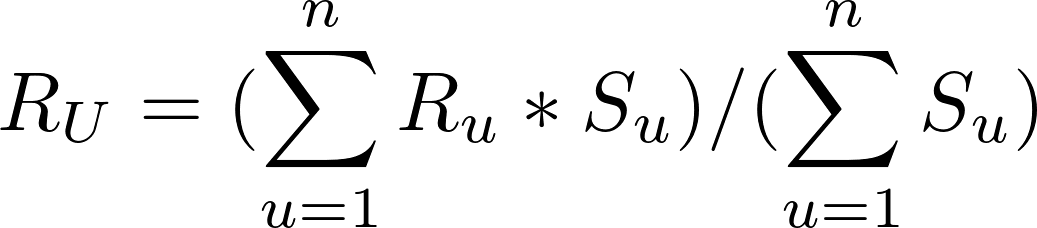

Image Source: https://realpython.com/build-recommendation-engine-collaborative-filtering/

In [18]:
def get_top_10_books(target_user_id,centered_user_item_matrix, most_sim_users,user_item_matrix):
    not_read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].isna()].index
    predicted_ratings = {}

    for book in not_read:
        numerator = 0
        denominator = 0
        for similar_user, sim_score in most_sim_users.items():
            similar_user_rating = centered_user_item_matrix.at[similar_user,book]
            if not (pd.isna(similar_user_rating)):
                numerator += similar_user_rating * sim_score
                denominator += sim_score
    
        if denominator > 0 :
            predicted_ratings[book] = numerator/denominator
    
        else:
            predicted_ratings[book] = np.nan

    
    predicted_ratings = pd.Series(predicted_ratings)
    target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
    predicted_ratings += target_user_avg_rating
    predicted_ratings = predicted_ratings.clip(lower=1, upper=10)
    
    top_10_books = predicted_ratings.dropna().sort_values(ascending=False).head(10)

    
    top_10_books = pd.DataFrame(list(top_10_books.items()), columns=['Book Title', 'Predicted Rating'])
    return top_10_books

top_10_books = get_top_10_books(target_user_id,centered_user_item_matrix, most_sim_users,user_item_matrix)

print("Recommended Books for UserID: ", target_user_id)
display(top_10_books)

Recommended Books for UserID:  243


,Book Title,Predicted Rating
0,the virgin blue,6.805
1,dont sweat the small stuff with your family si...,5.180
2,the night crew,4.480
3,foucaults pendulum,3.680
4,the country of the pointed firs,3.180
5,my brother sam is dead point,2.680
6,pearl harbor movie tiein,1.430
7,empire falls,1.180
8,the prodigal spy,1.000
9,the adventures of huckleberry finn penguin cla...,1.000


### Accuracy Analysis
The above code can be used to recommend the top 10 books to a user based on the ratings similar users have given other books that the target had not yet read and using this ratings to predict the rating the target user might give every book in the dataset they have not read. To determine whether this recommendation engine is accurate mean absolute error, mean squared error, and root mean squared error are computed.

Example error calculations for the predicted ratings of one target user:

In [19]:
target_user_id = 243
print("Target User ID:", target_user_id)

read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index
#print(read)

collab_filtering_ratings  = {}

for book in read:
    numerator = 0
    denominator = 0
    for similar_user, sim_score in most_sim_users.items():
        similar_user_rating = centered_user_item_matrix.at[similar_user,book]
        if not (pd.isna(similar_user_rating)):
            numerator += similar_user_rating * sim_score
            denominator += sim_score

    if denominator > 0 :
        collab_filtering_ratings[book] = numerator/denominator

    else:
        collab_filtering_ratings[book] = np.nan


collab_filtering_ratings = pd.Series(collab_filtering_ratings)
target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
collab_filtering_ratings += target_user_avg_rating
collab_filtering_ratings = collab_filtering_ratings.apply(lambda x: 0 if x < 0 else x)
collab_filtering_ratings = collab_filtering_ratings.apply(lambda x: 10 if x > 10 else x)
#display(collab_filtering_ratings)

actual_user_ratings = {}

for book in read:
    actual_user_ratings[book] = user_item_matrix.at[target_user_id, book]

actual_user_ratings = pd.Series(actual_user_ratings)

#display(actual_user_ratings)

valid_entries = collab_filtering_ratings.notna()
#print(collab_filtering_ratings[valid_entries])

errors = collab_filtering_ratings[valid_entries] - actual_user_ratings[valid_entries]

abs_errors = errors.abs()
squared_errors = errors ** 2

MAE = abs_errors.mean()

MSE = squared_errors.mean()

RMSE = MSE **.5

# print("Errors:")
# print(errors)
print("\nMAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)

Target User ID: 243

MAE: 1.7513837450509284
MSE: 5.039303368794987
RMSE: 2.244839274601856


Total cummulative error for all errors from all users in the dataset:

In [20]:
def calc_error_for_user(target_user_id,centered_user_item_matrix, user_item_matrix, most_sim_users):
    read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index

    collab_filtering_ratings  = {}

    for book in read:
        numerator = 0
        denominator = 0
        for similar_user, sim_score in most_sim_users.items():
            similar_user_rating = centered_user_item_matrix.at[similar_user,book]
            if not (pd.isna(similar_user_rating)):
                numerator += similar_user_rating * sim_score
                denominator += sim_score
    
        if denominator > 0 :
            collab_filtering_ratings[book] = numerator/denominator
    
        else:
            collab_filtering_ratings[book] = np.nan
    
    collab_filtering_ratings = pd.Series(collab_filtering_ratings)
    target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
    collab_filtering_ratings += target_user_avg_rating
    collab_filtering_ratings = collab_filtering_ratings.apply(lambda x: 0 if x < 0 else x)
    collab_filtering_ratings = collab_filtering_ratings.apply(lambda x: 10 if x > 10 else x)
    #display(collab_filtering_ratings)

    actual_user_ratings = {}

    for book in read:
        actual_user_ratings[book] = user_item_matrix.at[target_user_id, book]
    
    actual_user_ratings = pd.Series(actual_user_ratings)
    
    #display(actual_user_ratings)
    
    valid_entries = collab_filtering_ratings.notna()
    
    errors = collab_filtering_ratings[valid_entries] - actual_user_ratings[valid_entries]

    return errors

user_ids = user_item_matrix.index.tolist()
all_user_errors  = []

for user_id in user_ids:
    target_user_id = user_id
    errors = calc_error_for_user(target_user_id,centered_user_item_matrix, user_item_matrix, most_sim_users)
    all_user_errors.extend(errors.tolist())


all_user_errors = pd.Series(all_user_errors)
abs_errors = all_user_errors.abs()
squared_errors = all_user_errors ** 2

MAE = abs_errors.mean()

MSE = squared_errors.mean()

RMSE = MSE **.5

# print("Error Scores:")

print("\nMAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)



MAE: 3.2921025534117714
MSE: 20.424389463279677
RMSE: 4.519335068710848


# Item-Based Collaborative Filtering
**The goal of this portion of the project is to recommend books to a target user predicted ratings computed from the scores the target user has given to similar items and then finding the highest-rated items of those not read by the target user.**

### Item-User-Rating Matrix
This matrix is rearranged from previously to more easily format for item-item similarity later on. 

In [21]:
item_user_matrix = merged_df.pivot(index = "Title", columns = "User", values = "Rating")
display(item_user_matrix.head())
item_user_matrix.info()

User,8,17,53,69,99,114,160,183,232,242,...,278641,278663,278694,278723,278771,278774,278838,278843,278851,278854
Title,,,,,,,,,,,,,,,,,,,,,
a court of chaos the chronicles of amber series book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a sign of the unicorn amber novels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a b c murders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a baby for emily silhouette special edition no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a bachelor and a baby the mom squad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 25377 entries, a  court of chaos the chronicles of amber series book to zweimal ist einmal zuviel
Columns: 18744 entries, 8 to 278854
dtypes: float64(18744)
memory usage: 3.5+ GB


The item-user matrix is centered and filled as done previously in user-based collaborative filtering.

In [22]:
row_avg = item_user_matrix.mean(axis=1,skipna=True)
centered_item_user_matrix = item_user_matrix.sub(row_avg,axis=0)

display(centered_item_user_matrix.head())
centered_item_user_matrix = centered_item_user_matrix.dropna(how='all')

filled_centered_item_user_matrix = centered_item_user_matrix.fillna(0)

display(filled_centered_item_user_matrix.head())

User,8,17,53,69,99,114,160,183,232,242,...,278641,278663,278694,278723,278771,278774,278838,278843,278851,278854
Title,,,,,,,,,,,,,,,,,,,,,
a court of chaos the chronicles of amber series book,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a sign of the unicorn amber novels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a b c murders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a baby for emily silhouette special edition no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a bachelor and a baby the mom squad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


User,8,17,53,69,99,114,160,183,232,242,...,278641,278663,278694,278723,278771,278774,278838,278843,278851,278854
Title,,,,,,,,,,,,,,,,,,,,,
a court of chaos the chronicles of amber series book,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a sign of the unicorn amber novels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a b c murders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a baby for emily silhouette special edition no,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a bachelor and a baby the mom squad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Item-Item Similarity Matrix
In the case of item-based collaborative filtering, item-item similarity is compute for each item vector through cosine similarity. Items are considered similar if they receive a similar ratings from the same user. 

In [23]:
item_similarity = cosine_similarity(filled_centered_item_user_matrix)
itemsimilarityDF = pd.DataFrame(item_similarity, columns=filled_centered_item_user_matrix.index, index=filled_centered_item_user_matrix.index)

display(itemsimilarityDF.head())

Title,a court of chaos the chronicles of amber series book,a sign of the unicorn amber novels,a b c murders,a baby for emily silhouette special edition no,a bachelor and a baby the mom squad,a bad bad day my first hello reader,a beautiful mind a biography of john forbes nash jr,a beautiful mind a biography of john forbes nash jr winner of the nobel prize in economics,a beautiful mind the life of mathematical genius and nobel laureate john nash,a bed by the window a novel of mystery and redemption,...,zombies dont play soccer adventures of the bailey school kids,zombies of the gene pool,zone aarogaa ne,zorba the greek,zoya,zoyas story an afghan womans struggle for freedom,zuiderkruis roman,zwaalf,zwei frauen das buch zum film roman,zweimal ist einmal zuviel
Title,,,,,,,,,,,,,,,,,,,,,
a court of chaos the chronicles of amber series book,1.000000,0.566829,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,-0.003658,0.000000,0.0,0.000000,0.000000,0.0
a sign of the unicorn amber novels,0.566829,1.000000,-0.215865,0.0,0.0,0.000000,0.0,0.0,0.014642,0.0,...,0.0,0.0,0.0,0.0,-0.050765,0.000000,0.0,-0.075155,0.031157,0.0
a b c murders,0.000000,-0.215865,1.000000,0.0,0.0,0.000000,0.0,0.0,-0.058140,0.0,...,0.0,0.0,0.0,0.0,0.207859,0.000000,0.0,0.298419,-0.123718,0.0
a baby for emily silhouette special edition no,0.000000,0.000000,0.000000,1.0,0.0,0.039245,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.002987,0.000000,0.0,0.000000,0.000000,0.0
a bachelor and a baby the mom squad,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.019432,0.041503,0.0,0.000000,0.000000,0.0


### Most Similar Items to Target Item (out of subset of books target user has read)

In [24]:
# Do not change function
def get_sim_items_read(target_user_id,target_item_id, itemsimilarityDF,centered_user_item_matrix):
    read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index
    #display(read)
    target_item_similarities = itemsimilarityDF.loc[target_item_id]
    target_item_similarities = target_item_similarities.drop(target_item_id)
    target_item_similarities = target_item_similarities[target_item_similarities.index.isin(read)]
    #print(target_item_similarities)

    most_sim_items_read = target_item_similarities.sort_values(ascending=False).head(10)

    return most_sim_items_read


#Choose different target userID from dataset
target_user_id = 243
target_item_id = "a b c murders"

most_sim_items_read = get_sim_items_read(target_user_id,target_item_id, itemsimilarityDF,centered_user_item_matrix)
display(most_sim_items_read)

Title
by the rivers of babylon                      0.357708
errands                                       0.317978
the macgregors serena caine the macgregors    0.281400
the charm school                              0.268807
season of the machete                         0.227305
silent snow                                   0.192070
the midnight club                             0.185103
bleachers                                     0.146268
summer of storms                              0.143505
deception point                               0.132945
Name: a b c murders, dtype: float64

### Recommend Top 10 Books to Target User (Item-Based Collaborative Filtering)

In [25]:
def get_top_10_books_itembased(target_user_id,centered_user_item_matrix,user_item_matrix,itemsimilarityDF):
    not_read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].isna()].index
    
    predicted_ratings_itembased = {}

    for book in not_read:
        numerator = 0
        denominator = 0
        most_sim_items_read = get_sim_items_read(target_user_id,book, itemsimilarityDF,centered_user_item_matrix)
        for similar_item, sim_score in most_sim_items_read.items():
            similar_item_rating = centered_user_item_matrix.at[target_user_id,similar_item]
            if not (pd.isna(similar_item_rating)):
                numerator += similar_item_rating * sim_score
                denominator += sim_score
    
        if denominator > 0 :
            predicted_ratings_itembased[book] = numerator/denominator
    
        else:
            predicted_ratings_itembased[book] = np.nan

    
    predicted_ratings_itembased = pd.Series(predicted_ratings_itembased)
    target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
    predicted_ratings_itembased += target_user_avg_rating
    predicted_ratings_itembased = predicted_ratings_itembased.clip(lower=1, upper=10)
    
    top_10_books_itembased = predicted_ratings_itembased.dropna().sort_values(ascending=False).head(10)

    
    top_10_books_itembased = pd.DataFrame(list(top_10_books_itembased.items()), columns=['Book Title', 'Predicted Rating'])
    return top_10_books_itembased



target_user_id = 243
top_10_books_itembased = get_top_10_books_itembased(target_user_id,centered_user_item_matrix, user_item_matrix,itemsimilarityDF)

print("Recommended Books for UserID: ", target_user_id)
display(top_10_books_itembased)

Recommended Books for UserID:  243


,Book Title,Predicted Rating
0,ne le dis a personne,10.000000
1,maraae stellaire,10.000000
2,le combat ordinaire tome,10.000000
3,les baabaas de la consigne automatique,10.000000
4,duel of dragons dragonsword no,9.971317
5,the tough guide to fantasyland,9.383005
6,professor unrat,9.000000
7,red dwarf omnibus,9.000000
8,code complete,9.000000
9,a point of honor,9.000000


### Accuracy Analysis

In [26]:
target_user_id = 243
print("Target User ID:", target_user_id)

read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index
#print(read)

collab_filtering_ratings_itembased  = {}


for book in read:
    numerator = 0
    denominator = 0
    most_sim_items_read = get_sim_items_read(target_user_id, book, itemsimilarityDF,centered_user_item_matrix)
    
    for similar_item, sim_score in most_sim_items_read.items():
        similar_item_rating = centered_user_item_matrix.at[target_user_id,similar_item]
        if not (pd.isna(similar_item_rating)):
            numerator += similar_item_rating * sim_score
            denominator += sim_score

    if denominator > 0 :
        collab_filtering_ratings_itembased[book] = numerator/denominator

    else:
        collab_filtering_ratings_itembased[book] = np.nan


collab_filtering_ratings_itembased = pd.Series(collab_filtering_ratings_itembased)
target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
collab_filtering_ratings_itembased += target_user_avg_rating
collab_filtering_ratings_itembased = collab_filtering_ratings_itembased.apply(lambda x: 0 if x < 0 else x)
collab_filtering_ratings_itembased = collab_filtering_ratings_itembased.apply(lambda x: 10 if x > 10 else x)
#display(collab_filtering_ratings)

actual_user_ratings = {}

for book in read:
    actual_user_ratings[book] = user_item_matrix.at[target_user_id, book]

actual_user_ratings = pd.Series(actual_user_ratings)

#display(actual_user_ratings)

valid_entries = collab_filtering_ratings_itembased.notna()
#print(collab_filtering_ratings[valid_entries])

errors = collab_filtering_ratings_itembased[valid_entries] - actual_user_ratings[valid_entries]

abs_errors = errors.abs()
squared_errors = errors ** 2

MAE = abs_errors.mean()

MSE = squared_errors.mean()

RMSE = MSE **.5

# print("Errors:")
# print(errors)
print("\nMAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)

Target User ID: 243

MAE: 1.7225927303613005
MSE: 5.879882258481261
RMSE: 2.424846852582913


In [27]:
# Too computationally expense to compute inside loop
item_sim_cache = {
    item: itemsimilarityDF.loc[item].drop(item)
    for item in itemsimilarityDF.index
}


# Do not change function
def get_sim_items_read_cache(target_user_id,target_item_id, item_sim_cache,centered_user_item_matrix):
    read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index
    #display(read)
    target_item_similarities = item_sim_cache[target_item_id]
    
    target_item_similarities = target_item_similarities[target_item_similarities.index.isin(read)]
    #print(target_item_similarities)

    most_sim_items_read_cache = target_item_similarities.sort_values(ascending=False).head(10)

    return most_sim_items_read_cache



def calc_error_for_user_itembased(target_user_id,centered_user_item_matrix, user_item_matrix, item_sim_cache):
    read = centered_user_item_matrix.loc[target_user_id][user_item_matrix.loc[target_user_id].notna()].index

    collab_filtering_ratings_itembased  = {}

    for book in read:
        numerator = 0
        denominator = 0
        most_sim_items_read_cache = get_sim_items_read_cache(target_user_id, book, item_sim_cache,centered_user_item_matrix)
        
        for similar_item, sim_score in most_sim_items_read_cache.items():
            similar_item_rating = centered_user_item_matrix.at[target_user_id,similar_item]
            if not (pd.isna(similar_item_rating)):
                numerator += similar_item_rating * sim_score
                denominator += sim_score
    
        if denominator > 0 :
            collab_filtering_ratings_itembased[book] = numerator/denominator
    
        else:
            collab_filtering_ratings_itembased[book] = np.nan
    
    collab_filtering_ratings_itembased = pd.Series(collab_filtering_ratings_itembased)
    target_user_avg_rating = user_item_matrix.loc[target_user_id].mean(skipna=True)
    collab_filtering_ratings_itembased += target_user_avg_rating
    collab_filtering_ratings_itembased = collab_filtering_ratings_itembased.apply(lambda x: 0 if x < 0 else x)
    collab_filtering_ratings_itembased = collab_filtering_ratings_itembased.apply(lambda x: 10 if x > 10 else x)
    #display(collab_filtering_ratings_itembased)

    actual_user_ratings = {}

    for book in read:
        actual_user_ratings[book] = user_item_matrix.at[target_user_id, book]
    
    actual_user_ratings = pd.Series(actual_user_ratings)
    
    #display(actual_user_ratings)
    
    valid_entries = collab_filtering_ratings_itembased.notna()
    
    errors = collab_filtering_ratings_itembased[valid_entries] - actual_user_ratings[valid_entries]

    return errors

user_ids = user_item_matrix.index.tolist()
all_user_errors_itembased  = []

for user_id in user_ids:
    target_user_id = user_id
    errors = calc_error_for_user_itembased(target_user_id,centered_user_item_matrix, user_item_matrix, item_sim_cache)
    all_user_errors_itembased.extend(errors.tolist())


all_user_errors_itembased = pd.Series(all_user_errors_itembased)
abs_errors = all_user_errors_itembased.abs()
squared_errors = all_user_errors_itembased ** 2

MAE = abs_errors.mean()

MSE = squared_errors.mean()

RMSE = MSE **.5

# print("Error Scores:")

print("\nMAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)



MAE: 1.0311838135132423
MSE: 3.144872746530773
RMSE: 1.773378906644255


### Datasets Used

https://www.kaggle.com/datasets/saurabhbagchi/books-dataset
https://www.kaggle.com/datasets/jdobrow/57000-books-with-metadata-and-blurbs

# Resources

https://developers.google.com/machine-learning/recommendation/content-based/basics
https://www.youtube.com/watch?v=n3RKsY2H-NE&t=12s
https://365datascience.com/tutorials/how-to-build-recommendation-system-in-python/
https://realpython.com/build-recommendation-engine-collaborative-filtering/
https://www.geeksforgeeks.org
https://medium.com/@sruthy.sn91/overcoming-data-sparsity-with-collaborative-filtering-e9a3519376f5
https://www.geeksforgeeks.org/ml-one-hot-encoding/